## Predict and plot minimal example
This notebook contains a script to predict and plot the target and prediction for two example station - the station POVE that is also mentioned in the accompanying paper and the station MCHL as an additional example

In [1]:
import datetime
import multiprocessing
import matplotlib.pyplot as plt
import yaml
import pathlib
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from datagenerator import EncapsulatedTimeSeriesDataset
from models import ModTCN
from preprocessing_utils import inferece_loop
from tqdm import trange

In [10]:
def eval_main(model_path: str | pathlib.Path, param_file: str | pathlib.Path):
    print('START EVAL SCRIPT')
    # ----------------
    # env set up
    use_cuda = torch.cuda.is_available()
    device_str = "cuda:0" if use_cuda else "cpu"
    device = torch.device(device_str)
    torch.backends.cudnn.benchmark = True
    print(f'Using device: {device} - {torch.cuda.get_device_name(device)}')

    cur_proc = multiprocessing.current_process().name
    # ------------------
    # load parameters
    with open(param_file, 'r') as params_in:
        params = yaml.safe_load(params_in)

    # ---------------
    # select checkpoint and load file
    checkpoint = torch.load(model_path)
    model_state = checkpoint['model']

    # ----------------
    # init model
    model = ModTCN(seq_len=params['feature_length'] if not params['diff'] else params['feature_length'] - 1,
                   num_seq_feat=len(params['features']),
                   dropout_rate=params['dropout_rate'],
                   num_channels=params['num_channels'],
                   kernel_size=params['kernel_size'],
                   kernel_initializer=params['kernel_initializer'],
                   use_skip_connections=params['use_skip_connections'],
                   causal=params['causal'],
                   device=device)

    model.cuda(device=device)

    model.load_state_dict(model_state)

    # ------------
    # set params
    params['test_station_csv'] = 'data/stations_test_long.csv'
    params['feature_dir'] = 'data/ESMGFZ/'

    # ---------------
    # load hold out test data
    test_df = pd.read_csv(params['test_station_csv'])
    test_df = test_df.reset_index(drop=True)

    sta_db = dict()

    # init data loaders
    dataset = EncapsulatedTimeSeriesDataset
    
    test_df = test_df.loc[test_df.Sta.isin(['POVE_0', 'MCHL_0'])].reset_index(drop=True)
    stats_df = pd.read_csv('./data/norm_stats_new.csv', index_col=0)

    for irow in trange(test_df.shape[0], desc=f'{cur_proc}'):
        row = test_df.iloc[irow].copy()

        sta_db[row.Sta] = dict()

        test_dataset = dataset(
            station_df=pd.DataFrame([row]).reset_index(drop=True),  # params['train_station_csv'],  # train_df,
            features=params['features'],
            target=params['target'],
            feature_dir=params['feature_dir'],
            target_dir=params['target_dir'],
            feature_length=params['feature_length'], feature_stride=params['feature_stride'],
            target_length=params['target_length'], target_stride=params['target_stride'],
            offset=params['offset'],
            lowpassfilter=params['lowpassfilter'] if 'lowpassfilter' in params.keys() else False,
            ntl_lowpassfilter=params['ntl_lowpassfilter'] if 'ntl_lowpassfilter' in params.keys() else False,
            norm_stats=params['norm_stats'],
            diff=params['diff'],
            eval_mode=True
        )

        test_dataloader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False,
                                     drop_last=False, pin_memory=True, pin_memory_device=device_str,
                                     num_workers=0, persistent_workers=False)

        tar, pred, time = inferece_loop(dataloader=test_dataloader, model=model)

        sta_db[row.Sta]['tar'] = np.array(tar)
        sta_db[row.Sta]['pred'] = np.array(pred)
        sta_db[row.Sta]['time'] = time

        time = np.array(time)[-1, :, -1]
        time = np.array([datetime.date.fromordinal(t) for t in time])
        tar = tar[:, -1, -1]
        pred = pred[:, -1, -1]

        tar = (tar * stats_df.loc['data', 'sig']) + stats_df.loc['data', 'mu']
        pred = (pred * stats_df.loc['data', 'sig']) + stats_df.loc['data', 'mu']

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(time, tar, label='NGL target')
        ax.plot(time, pred, label='TCN prediction')
        ax.set_title(row.Sta)
        ax.grid()
        ax.legend()
        ax.set_ylabel('Vert. Displacement [mm]')
        plt.show()

START EVAL SCRIPT
Using device: cuda:0 - NVIDIA GeForce RTX 3050 Ti Laptop GPU


/home/kaan/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
MainProcess:   0%|          | 0/2 [00:00<?, ?it/s]

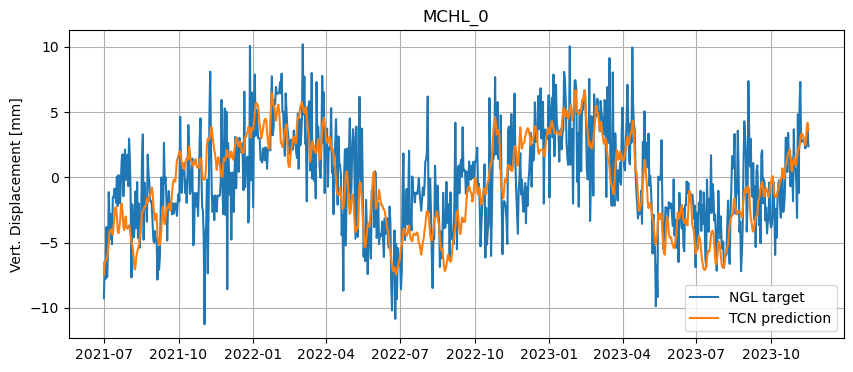

MainProcess:  50%|█████     | 1/2 [00:08<00:08,  8.48s/it]

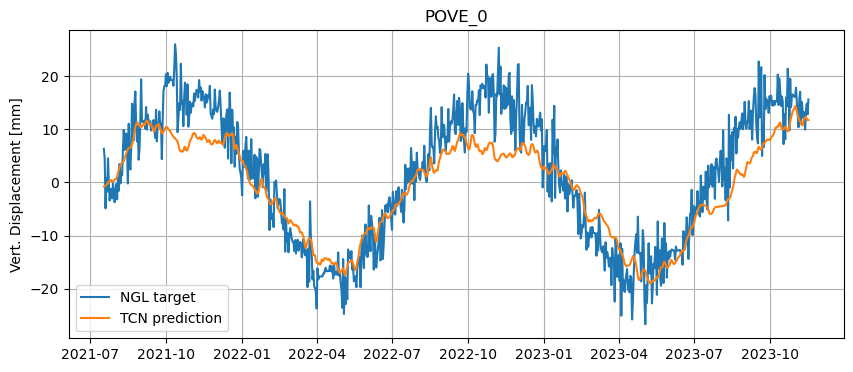

MainProcess: 100%|██████████| 2/2 [00:16<00:00,  8.35s/it]


In [11]:
eval_main(model_path='data/TCN_model.pth', param_file='data/params.yaml')